In [1]:
!pip install mmcv-full
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

     |████████████████████████████████| 317kB 9.0MB/s 
     |████████████████████████████████| 194kB 46.0MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.8-cp37-cp37m-linux_x86_64.whl size=29368772 sha256=f9f1427f998d065ab3960cb2b007ae1dce126d7b2ce59fa784f07dfbe72b9634
  Stored in directory: /root/.cache/pip/wheels/5a/0d/c3/627bb7a31df052473f9edd2812702d4a0b2e302cb6932c9a91
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 19286, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 19286 (delta 94), reused 174 (delta 80), pack-reused 19062
Receiving objects: 100% (19286/19286), 23.57 MiB | 26.26 MiB/s, done.
Resolving deltas: 100% (13495/13495), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
wr

In [1]:
# 언타임 다시 시작 후 아래 수행.
from mmdet.apis import init_detector, inference_detector
import mmcv

In [27]:
import glob
import xml.etree.ElementTree as ET
import pandas as pd

from sklearn.model_selection import train_test_split

### Oxford Pet Dataset 다운로드
image와 annotation을 압축파일로 각각 download 수행

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-07-09 15:08:37--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  20.7MB/s    in 37s     

2021-07-09 15:09:15 (20.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-07-09 15:09:15--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  10.8MB/s    in 1.7s    

2021-07-09 15:09:17 (10.8 M

In [ ]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

### 이미지 파일과 annotation 파일 살펴보기

In [ ]:
!ls -lia ./data/images/Abyss*.jpg

In [ ]:
!ls -lia ./data/images

In [10]:
!cat ./data/annotations/xmls/Abyssinian_1.xml

<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>


In [15]:
def get_bboxes_from_xml_tree(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  bbox_names = []
  bboxes = []

  for obj in root.findall('object'):
    box_name = obj.find('name').text

    bound_box = obj.find('bndbox')
    x1 = int(bound_box.find('xmin').text)
    y1 = int(bound_box.find('ymin').text)
    x2 = int(bound_box.find('xmax').text)
    y2 = int(bound_box.find('ymax').text)

    bbox_names.append(box_name)
    bboxes.append([x1, y1, x2, y2])
  
  return bbox_names, bboxes

In [16]:
get_bboxes_from_xml_tree('/content/data/annotations/xmls/Abyssinian_1.xml')

(['cat'], [[333, 72, 425, 158]])

### train / val / test의 image, annotation 메타 파일 보기
- train과 valid용 meta파일을 별도로 만들어줌

In [18]:
!cd /content/data/annotations; cat trainval.txt | head

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


In [21]:
pet_df = pd.read_csv('/content/data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', ' etc1', ' etc2'])
pet_df.head()

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [24]:
pet_df['img_name'].value_counts()

wheaten_terrier_113           1
scottish_terrier_189          1
yorkshire_terrier_175         1
english_cocker_spaniel_127    1
english_setter_103            1
                             ..
British_Shorthair_210         1
Ragdoll_198                   1
Sphynx_205                    1
Russian_Blue_102              1
Bengal_171                    1
Name: img_name, Length: 3680, dtype: int64

In [26]:
pet_df['class_name'] = pet_df['img_name'].apply(lambda x: x[:x.rfind('_')])
pet_df.head()

,img_name,class_id,etc1,etc2,class_name
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian
4,Abyssinian_104,1,1,1,Abyssinian


In [29]:
train_df, val_df = train_test_split(pet_df, test_size=0.1, stratify=pet_df['class_id'], random_state=444)

In [32]:
print(train_df['class_id'].value_counts(), val_df['class_id'].value_counts())

37    90
22    90
34    90
32    90
30    90
28    90
26    90
24    90
20    90
35    90
18    90
16    90
14    90
10    90
6     90
4     90
36    90
1     90
3     90
19    90
31    90
29    90
27    90
25    90
5     90
21    90
17    90
15    90
11    90
9     90
7     90
2     90
33    89
23    87
13    86
8     86
12    84
Name: class_id, dtype: int64 37    10
36    10
17    10
16    10
15    10
14    10
13    10
11    10
10    10
9     10
8     10
7     10
6     10
5     10
4     10
3     10
2     10
18    10
19    10
20    10
21    10
35    10
34    10
33    10
32    10
31    10
30    10
29    10
28    10
27    10
26    10
25    10
24    10
22    10
1     10
12     9
23     9
Name: class_id, dtype: int64


In [33]:
train_df.head()

,img_name,class_id,etc1,etc2,class_name
2809,leonberger_168,20,2,14,leonberger
1740,staffordshire_bull_terrier_140,35,2,23,staffordshire_bull_terrier
1624,Siamese_136,33,1,11,Siamese
3248,saint_bernard_161,29,2,19,saint_bernard
772,great_pyrenees_124,16,2,10,great_pyrenees


In [34]:
train_df = train_df.sort_values(by='img_name')
val_df = val_df.sort_values(by='img_name')

In [35]:
train_df.head()

,img_name,class_id,etc1,etc2,class_name
1895,Abyssinian_1,1,1,1,Abyssinian
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian


In [47]:
train_df['img_name'].to_csv('./data/train.txt', sep=' ', header=False, index=False)
val_df['img_name'].to_csv('./data/val.txt', sep=' ', header=False, index=False)

In [49]:
pet_classes_list = pet_df['class_name'].unique().tolist()
print(pet_classes_list[:5])

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle']


In [50]:
!echo 'train list #####'; cat ./data/train.txt

train list #####
Abyssinian_1
Abyssinian_100
Abyssinian_101
Abyssinian_102
Abyssinian_103
Abyssinian_104
Abyssinian_105
Abyssinian_106
Abyssinian_107
Abyssinian_109
Abyssinian_11
Abyssinian_110
Abyssinian_112
Abyssinian_113
Abyssinian_114
Abyssinian_115
Abyssinian_116
Abyssinian_117
Abyssinian_118
Abyssinian_119
Abyssinian_12
Abyssinian_120
Abyssinian_121
Abyssinian_122
Abyssinian_123
Abyssinian_125
Abyssinian_126
Abyssinian_127
Abyssinian_128
Abyssinian_129
Abyssinian_13
Abyssinian_130
Abyssinian_131
Abyssinian_132
Abyssinian_133
Abyssinian_134
Abyssinian_135
Abyssinian_136
Abyssinian_137
Abyssinian_139
Abyssinian_14
Abyssinian_140
Abyssinian_141
Abyssinian_142
Abyssinian_143
Abyssinian_144
Abyssinian_145
Abyssinian_146
Abyssinian_148
Abyssinian_15
Abyssinian_151
Abyssinian_152
Abyssinian_153
Abyssinian_154
Abyssinian_155
Abyssinian_156
Abyssinian_157
Abyssinian_158
Abyssinian_159
Abyssinian_16
Abyssinian_160
Abyssinian_161
Abyssinian_165
Abyssinian_166
Abyssinian_167
Abyssinian_168
A

In [51]:
!echo ' valid list ###'; cat ./data/val.txt

 valid list ###
Abyssinian_10
Abyssinian_108
Abyssinian_111
Abyssinian_124
Abyssinian_138
Abyssinian_149
Abyssinian_150
Abyssinian_164
Abyssinian_169
Abyssinian_176
Bengal_100
Bengal_107
Bengal_11
Bengal_113
Bengal_122
Bengal_141
Bengal_151
Bengal_161
Bengal_178
Bengal_182
Birman_106
Birman_109
Birman_118
Birman_144
Birman_148
Birman_150
Birman_156
Birman_159
Birman_167
Birman_179
Bombay_10
Bombay_107
Bombay_120
Bombay_135
Bombay_136
Bombay_139
Bombay_14
Bombay_177
Bombay_178
Bombay_181
British_Shorthair_101
British_Shorthair_110
British_Shorthair_114
British_Shorthair_119
British_Shorthair_135
British_Shorthair_136
British_Shorthair_163
British_Shorthair_17
British_Shorthair_185
British_Shorthair_201
Egyptian_Mau_108
Egyptian_Mau_11
Egyptian_Mau_114
Egyptian_Mau_118
Egyptian_Mau_133
Egyptian_Mau_16
Egyptian_Mau_176
Egyptian_Mau_182
Egyptian_Mau_196
Maine_Coon_1
Maine_Coon_110
Maine_Coon_129
Maine_Coon_132
Maine_Coon_138
Maine_Coon_154
Maine_Coon_161
Maine_Coon_169
Maine_Coon_171
Maine

### mmdetection의 dataset format 변환


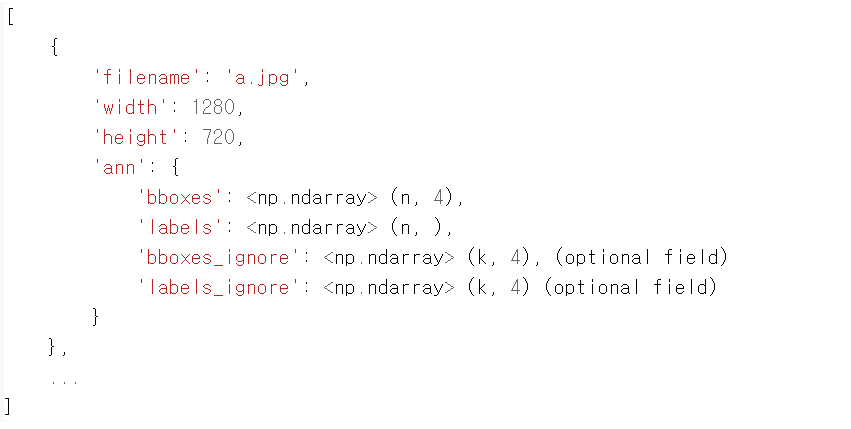

In [46]:
import copy
import os.path as osp

import mmcv
import numpy as np
import cv2

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

import xml.etree.ElementTree as ET

In [82]:
import xml.etree.ElementTree as ET

# 1개의 annotation 파일에서 bbox 정보 추출. 여러개의 object가 있을 경우 이들 object의 name과 bbox 좌표들을 list로 반환.
def get_bboxes_from_xml(anno_xml_file):
  anno_dir = anno_xml_file[:anno_xml_file.rfind('/')]
  xml_file = anno_xml_file[anno_xml_file.rfind('/')+1:]
  
  tree = ET.parse(anno_xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []

  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):
    #obj.find('name').text는 cat 이나 dog을 반환     
    #bbox_name = obj.find('name').text
    # object의 클래스명은 파일명에서 추출. 
    bbox_name = xml_file[:xml_file.rfind('_')]
    
    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)

    bboxes.append([x1, y1, x2, y2])
    bbox_names.append(bbox_name)

  return bbox_names, bboxes

In [98]:
PET_CLASSES = pet_df['class_name'].unique().tolist()

@DATASETS.register_module(force=True)
class PetDataset(CustomDataset):
  CLASSES = PET_CLASSES

  def load_annotations(self, ann_file):
    cat2label = {key: value for value, key in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    
    data_infos = []

    for img_id in image_list:
      filename = '{}/{}.jpg'.format(self.img_prefix, img_id)
      image = cv2.imread(filename)
      width, height = image.shape[:2]

      data_info = {'filename': filename,
                   'width': width,
                   'height': height}
      label_prefix = self.img_prefix.replace('images', 'annotations')
      anno_xml_file = osp.join(label_prefix, 'xmls/'+ str(img_id)+'.xml')
      
      if not osp.exists(anno_xml_file):
        continue
      
      bbox_names, bboxes = get_bboxes_from_xml(anno_xml_file)
      
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_name, bbox in zip(bbox_names, bboxes):
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          gt_labels.append(cat2label[bbox_name])
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)
      
      data_ann = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1,4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1,4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      data_info.update(ann=data_ann)

      data_infos.append(data_info)
  
    return data_infos



In [81]:
get_bboxes_from_xml('/content/data/annotations/xmls/Bengal_124.xml')

Bengal


(['Bengal'], [[52, 47, 147, 153]])

In [87]:
# 디버깅 용도로 클래스 제작 가능

class PetDataset_imsi():
  CLASSES = PET_CLASSES

  def __init__(self, data_root, ann_file, img_prefix):
    self.data_root = data_root
    self.ann_file = osp.join(data_root, ann_file)
    self.img_prefix = osp.join(data_root, img_prefix)

    self.data_infos = self.load_annotations(self.ann_file)

  def load_annotations(self, ann_file):
    cat2label = {key: value for value, key in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    
    data_infos = []

    for img_id in image_list:
      filename = '{}/{}.jpg'.format(self.img_prefix, img_id)
      image = cv2.imread(filename)
      width, height = image.shape[:2]

      data_info = {'filename': filename,
                   'width': width,
                   'height': height}
      label_prefix = self.img_prefix.replace('images', 'annotations')
      anno_xml_file = osp.join(label_prefix, 'xmls/'+ str(img_id)+'.xml')
      
      if not osp.exists(anno_xml_file):
        continue
      
      bbox_names, bboxes = get_bboxes_from_xml(anno_xml_file)
      
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_name, bbox in zip(bbox_names, bboxes):
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          gt_labels.append(cat2label[bbox_name])
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)
      
      data_ann = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1,4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1,4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      data_info.update(ann=data_ann)

      data_infos.append(data_info)
  
    return data_infos

In [88]:
# 디버깅 용도로 생성한 클래스를 생성하고 data_infos를 10개만 추출하여 생성된 데이터 확인. 
train_ds = PetDataset_imsi(data_root='/content/data', ann_file='train.txt', img_prefix='images')
print(train_ds.data_infos[:10])

[{'filename': '/content/data/images/Abyssinian_1.jpg', 'width': 400, 'height': 600, 'ann': {'bboxes': array([[333.,  72., 425., 158.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': '/content/data/images/Abyssinian_100.jpg', 'width': 500, 'height': 394, 'ann': {'bboxes': array([[151.,  71., 335., 267.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': '/content/data/images/Abyssinian_101.jpg', 'width': 313, 'height': 450, 'ann': {'bboxes': array([[ 54.,  36., 319., 235.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': '/content/data/images/Abyssinian_102.jpg', 'width': 465, 'height': 500, 'ann': {'bboxes': array([[ 23.,  27., 325., 320.]], dtype=float32), 'labels': array([0]), '

### Config 설정 후 Pretrained 된 모델을 다운하고 Inference

In [91]:
!cd mmdetection; mkdir checkpoints
!wget -O ./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-07-09 16:30:52--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

./mmdetection/check 100%[===================>] 159.54M  10.9MB/s    in 16s     

2021-07-09 16:31:09 (9.92 MB/s) - ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [92]:
config_file = './mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [93]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [94]:
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [95]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'


In [96]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생. 
!mkdir "/mydrive/pet_work_dir"

In [97]:
!nvidia-smi

Fri Jul  9 16:33:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [99]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 37
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정. 
cfg.work_dir = '/mydrive/pet_work_dir'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 5

cfg.runner.max_epochs = 5

# 평가 metric 설정. 
cfg.evaluation.metric = 'mAP'
# 평가 metric 수행할 epoch interval 설정. 
cfg.evaluation.interval = 5
# 학습 iteration시마다 모델을 저장할 epoch interval 설정. 
cfg.checkpoint_config.interval = 5

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨)
cfg.data.samples_per_gpu = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

- build__dataset으로 train config의 설정에 따른 train 용 dataset 생성
- build_detector로 train과 test config 반영하여 model 생성
- train_detector()로 model학습

In [100]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

In [101]:
dataset = [build_dataset(cfg.data.train)]
dataset

/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/datasets/custom.py:156: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


[
 PetDataset Train dataset with number of images 3303, and instance counts: 
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | category              | count | category                | count | category                      | count | category            | count | category                        | count |
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | 0 [Abyssinian]        | 89    | 1 [american_bulldog]    | 90    | 2 [american_pit_bull_terrier] | 90    | 3 [basset_hound]    | 90    | 4 [beagle]                      | 90    |
 | 5 [Bengal]            | 89    | 6 [Birman]              | 90    | 7 [Bombay]                    | 86    | 8 [boxer]           | 90    | 9 [British_Shorthair]           | 90    |
 | 10 [chihuahua]

In [102]:
%cd mmdetection

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = dataset[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

/content/mmdetection


/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [103]:
train_detector(model, dataset, cfg, distributed=False, validate=True)

2021-07-09 16:42:19,615 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2021-07-09 16:42:19,617 - mmdet - INFO - Use load_from_local loader
2021-07-09 16:42:19,740 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([38, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([38]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([148, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([148]).
2021-07-09 16:42:19,745 - mmdet - INFO - S

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 368/368, 7.8 task/s, elapsed: 47s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-07-09 18:03:23,233 - mmdet - INFO - 
+----------------------------+-----+------+--------+-------+
| class                      | gts | dets | recall | ap    |
+----------------------------+-----+------+--------+-------+
| Abyssinian                 | 10  | 52   | 0.900  | 0.509 |
| american_bulldog           | 10  | 50   | 0.900  | 0.706 |
| american_pit_bull_terrier  | 10  | 93   | 0.900  | 0.572 |
| basset_hound               | 10  | 86   | 1.000  | 0.953 |
| beagle                     | 10  | 74   | 1.000  | 0.372 |
| Bengal                     | 10  | 34   | 0.900  | 0.457 |
| Birman                     | 10  | 51   | 1.000  | 0.686 |
| Bombay                     | 10  | 53   | 1.000  | 0.959 |
| boxer                      | 10  | 61   | 1.000  | 0.523 |
| British_Shorthair          | 10  | 87   | 1.000  | 0.811 |
| chihuahua                  | 10  | 44   | 1.000  | 0.880 |
| Egyptian_Mau               | 9   | 37   | 0.889  | 0.610 |
| english_cocker_spaniel     | 10  | 97   |

### Checkpoint 저장된 model 파일이르 로딩하고 이를 이용하여 Inference

In [ ]:
from mmdet.apis import show_result_pyplot

from mmdet.apis import init_detector, inference_detector
import mmcv

chechpoint_file = ''
model_ckpt = init_detector(cfg, chechpoint_file, device='cuda:0')

# BGR
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.3)